In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

df = pd.read_csv('no_duplicates_fixed.csv')
print(df.columns)

Index(['FIPS', 'State', 'County', 'LowIncome_LowAccess', 'NoCar_LowAccess',
       'Snap_Participation', 'FreeLunch_Participation', 'WIC_Participation',
       'FoodBanks_Count', 'Adult_Diabetes', 'Adult_Obesity',
       'Recreation_Facility_Count', 'White_Pct', 'Hispanic_Pct', 'Black_Pct',
       'Asian_Pct', 'NativeAmerican_Pct', 'PacificIslander_Pct',
       '65_Older_Pct', '18_Younger_Pct', 'MedianHouseholdIncome',
       'PovertyRate', 'PopulationLoss', 'FoodInsecurity',
       'Grocery_Per_Thousand', 'Snap_Authorized_Stores_Count',
       'WIC_Authorized_Stores_Count', 'Food_Sales_Tax',
       'Fast_Food_Restaurants_PTH', 'Fast_Food_Expenditures_Per_Capita'],
      dtype='object')


<ipython-input-3-11082be87d79>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  food_comparison = df.groupby('FoodInsecurity_Level')[['Grocery_Per_Thousand', 'Fast_Food_Restaurants_PTH']].mean().reset_index()


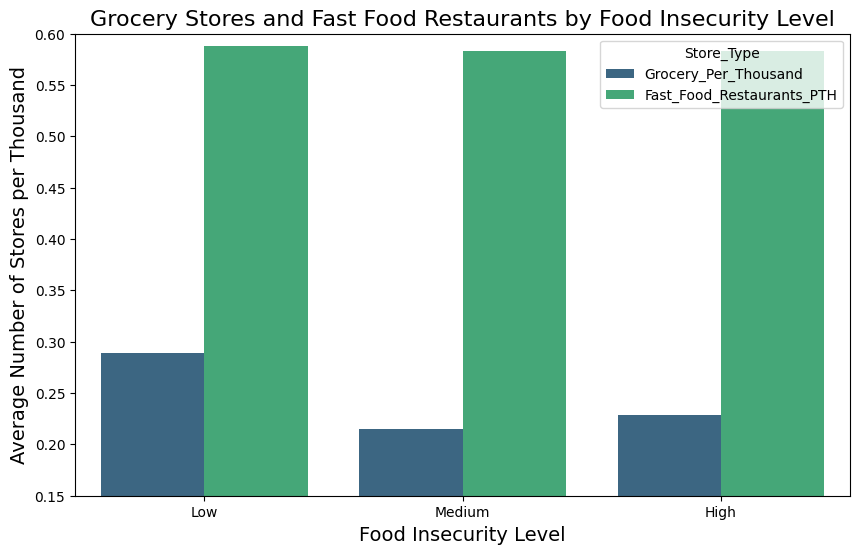

In [ ]:
# GROCERY STORES AND FAST FOOD RESTAURANTS BY FOOD INSECURITY LEVEL ------------------------------------------------------
# FoodInsecurity into Low, Medium, High
bins = [0, df['FoodInsecurity'].quantile(0.33), df['FoodInsecurity'].quantile(0.66), df['FoodInsecurity'].max()]
labels = ['Low', 'Medium', 'High']
df['FoodInsecurity_Level'] = pd.cut(df['FoodInsecurity'], bins=bins, labels=labels, include_lowest=True)
food_comparison = df.groupby('FoodInsecurity_Level')[['Grocery_Per_Thousand', 'Fast_Food_Restaurants_PTH']].mean().reset_index()

# plotting
plt.figure(figsize=(10, 6))
food_comparison_melted = pd.melt(food_comparison, id_vars='FoodInsecurity_Level',
                                 value_vars=['Grocery_Per_Thousand', 'Fast_Food_Restaurants_PTH'],
                                 var_name='Store_Type', value_name='Stores_Per_Thousand')
sns.barplot(x='FoodInsecurity_Level', y='Stores_Per_Thousand', hue='Store_Type', data=food_comparison_melted, palette='viridis')
plt.title('Grocery Stores and Fast Food Restaurants by Food Insecurity Level', fontsize=16)
plt.xlabel('Food Insecurity Level', fontsize=14)
plt.ylabel('Average Number of Stores per Thousand', fontsize=14)
plt.ylim(.15,.6)
plt.show()

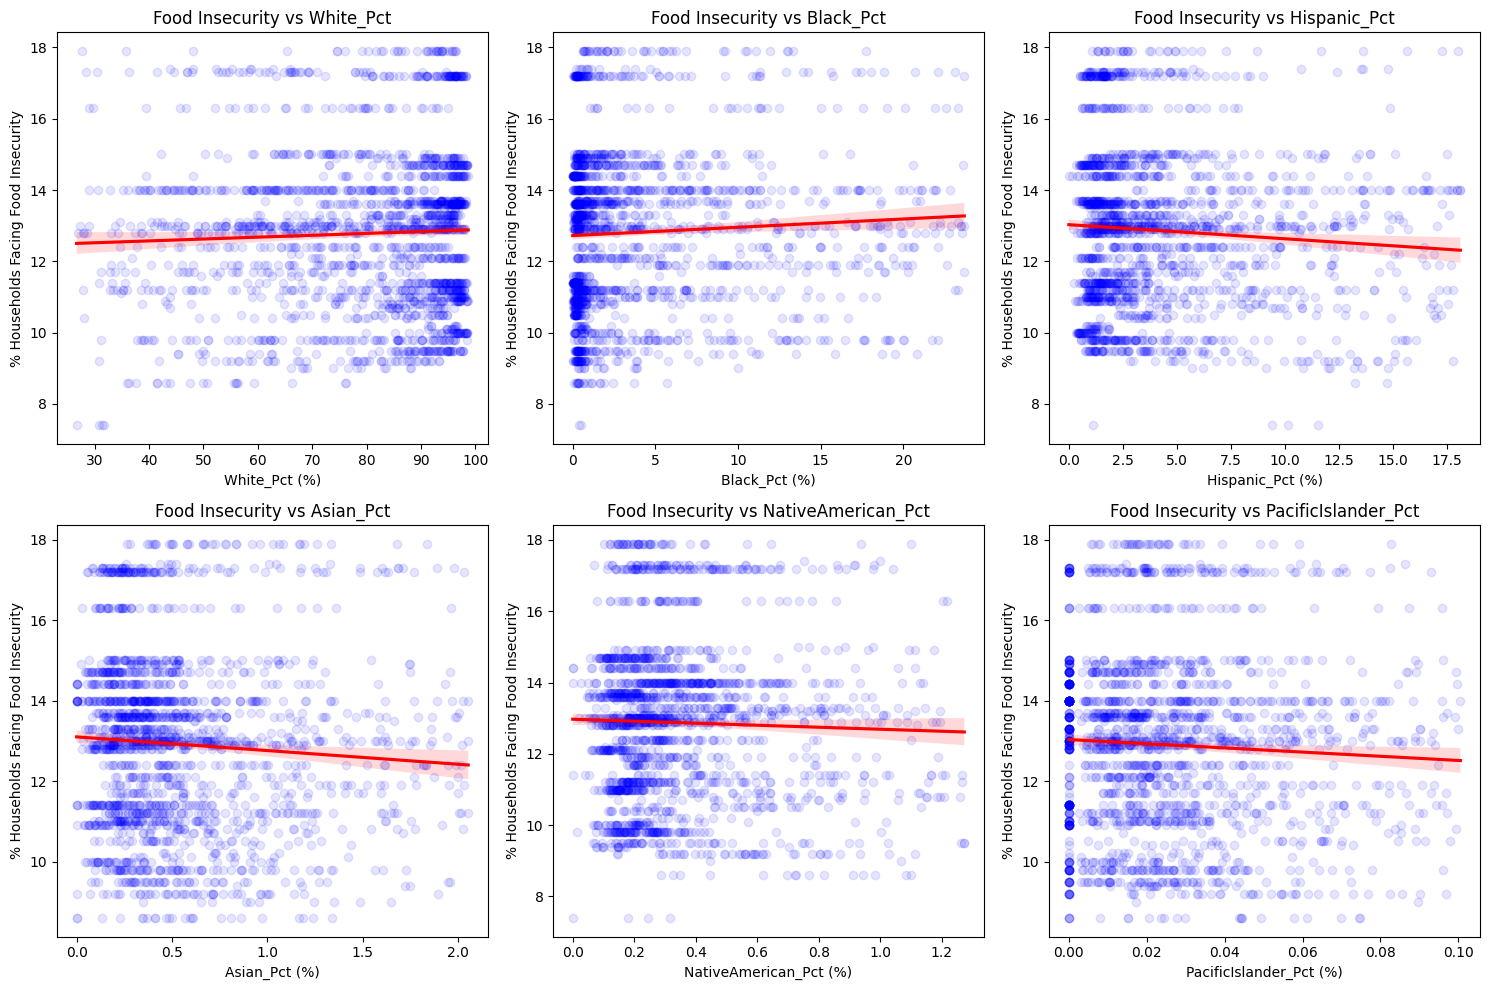

In [ ]:
# DEMOGRAPHIC REGRESSION ANALYSIS -----------------------------------------------------------------------------------
np.random.seed(42)
demographics = ['White_Pct', 'Black_Pct', 'Hispanic_Pct', 'Asian_Pct', 'NativeAmerican_Pct', 'PacificIslander_Pct']

# remove outliers
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

# grid 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# flatten axes
axes = axes.flatten()

# create a scatter plot with regression line for each race
for i, demographic in enumerate(demographics):
    ax = axes[i]
    filtered_df = remove_outliers(df, demographic)
    filtered_df = remove_outliers(filtered_df, 'FoodInsecurity')
    sample_df = filtered_df.sample(n=min(2000, len(filtered_df)), random_state=42)
    sns.regplot(x=sample_df[demographic], y=sample_df['FoodInsecurity'],
                scatter_kws={'color': 'blue', 'alpha': 0.1},
                line_kws={'color': 'red'}, ax=ax)  # ci=None removes confidence interval shading
    ax.set_title(f'Food Insecurity vs {demographic}')
    ax.set_xlabel(f'{demographic} (%)')
    ax.set_ylabel('% Households Facing Food Insecurity')
plt.tight_layout()
plt.show()



<ipython-input-17-f8fa3d7722ae>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="FoodAccess_Level", y="Adult_Obesity", data=df_clean, palette="coolwarm")


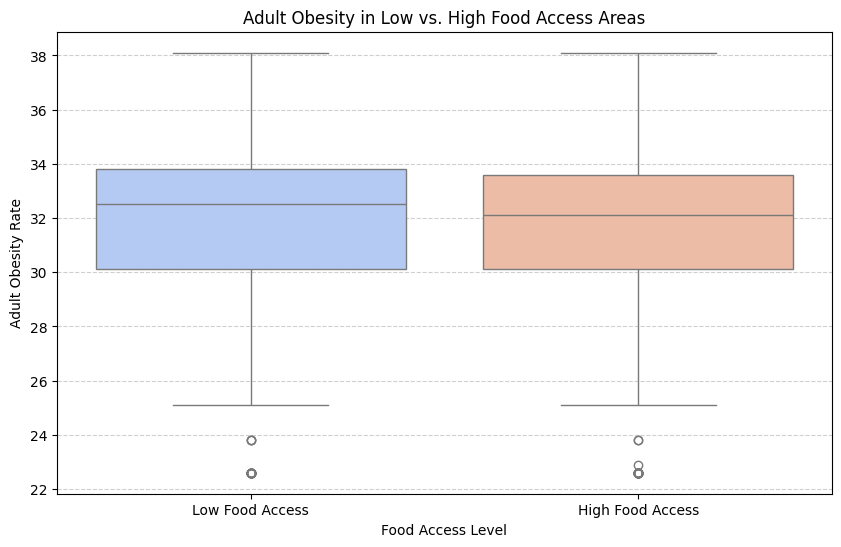

<ipython-input-17-f8fa3d7722ae>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="FoodAccess_Level", y="Adult_Diabetes", data=df_clean, palette="coolwarm")


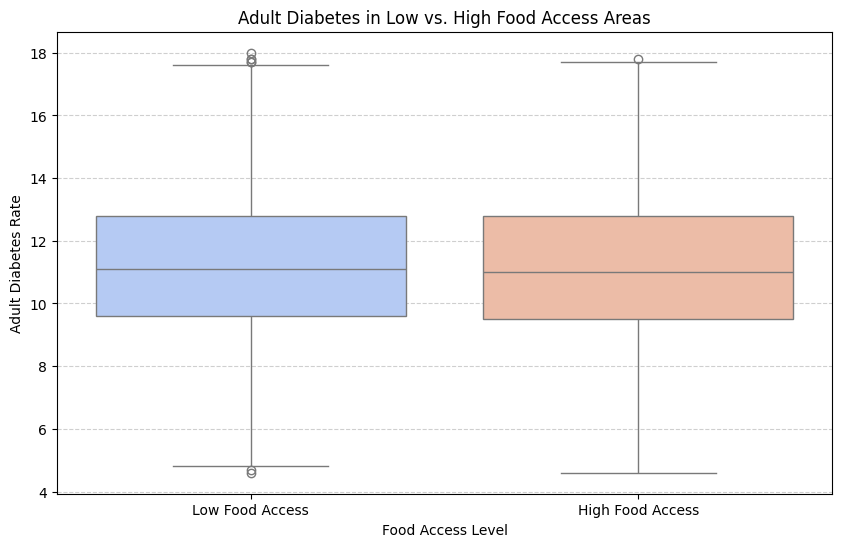

In [ ]:
# ADULT OBESITY/DIABETES IN LOW VS HIGH FOOD ACCESS AREAS -----------------------------------------------------------------------------
# Classifying areas as Low vs High food access
threshold = df["LowIncome_LowAccess"].median()  # Using median to split
df["FoodAccess_Level"] = df["LowIncome_LowAccess"].apply(lambda x: "Low Food Access" if x >= threshold else "High Food Access")

df_clean = remove_outliers(df, "Adult_Diabetes")

# box plots
plt.figure(figsize=(10, 6))
sns.boxplot(x="FoodAccess_Level", y="Adult_Obesity", data=df_clean, palette="coolwarm")
plt.xlabel("Food Access Level")
plt.ylabel("Adult Obesity Rate")
plt.title("Adult Obesity in Low vs. High Food Access Areas")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x="FoodAccess_Level", y="Adult_Diabetes", data=df_clean, palette="coolwarm")
plt.xlabel("Food Access Level")
plt.ylabel("Adult Diabetes Rate")
plt.title("Adult Diabetes in Low vs. High Food Access Areas")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

In [ ]:
# Split the data into two groups
low_access = df_clean[df_clean["FoodAccess_Level"] == "Low Food Access"]["Adult_Obesity"]
high_access = df_clean[df_clean["FoodAccess_Level"] == "High Food Access"]["Adult_Obesity"]

# t-test
t_stat, p_value = ttest_ind(low_access, high_access, equal_var=False)

print(t_stat)

# Split the data into two groups
low_access_d = df_clean[df_clean["FoodAccess_Level"] == "Low Food Access"]["Adult_Diabetes"]
high_access_d = df_clean[df_clean["FoodAccess_Level"] == "High Food Access"]["Adult_Diabetes"]

# t-test
t_stat_D, p_value = ttest_ind(low_access_d, high_access_d, equal_var=False)

print(t_stat_D)


1.5382168529520788
1.3044182457558733


<ipython-input-20-55cad54cc782>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="FoodAccess_Level", y="MedianHouseholdIncome", data=df_clean, palette="coolwarm")


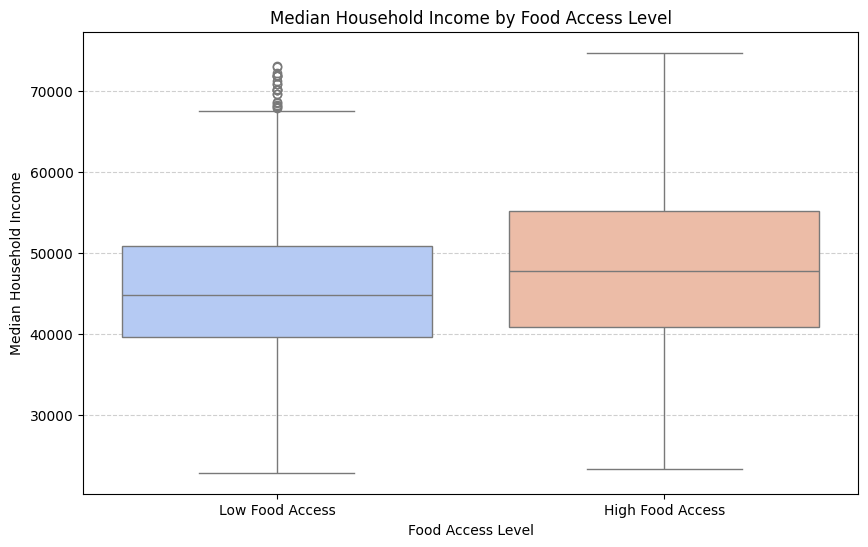

In [ ]:
# Median Household Income by Food Access Level ------------------------------------------------------------------------
threshold = df["LowIncome_LowAccess"].median()
df["FoodAccess_Level"] = df["LowIncome_LowAccess"].apply(lambda x: "Low Food Access" if x >= threshold else "High Food Access")

# Remove outliers
df_clean = remove_outliers(df, "MedianHouseholdIncome")

# Plot box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x="FoodAccess_Level", y="MedianHouseholdIncome", data=df_clean, palette="coolwarm")
plt.xlabel("Food Access Level")
plt.ylabel("Median Household Income")
plt.title("Median Household Income by Food Access Level")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

In [ ]:
# Split the data into two groups based on Food Access Level
low_access_income = df_clean[df_clean["FoodAccess_Level"] == "Low Food Access"]["MedianHouseholdIncome"]
high_access_income = df_clean[df_clean["FoodAccess_Level"] == "High Food Access"]["MedianHouseholdIncome"]

# t-test
t_stat_income, p_value_income = ttest_ind(low_access_income, high_access_income, equal_var=False)  # Welch's t-test
print(t_stat_income)

-8.591029779970897


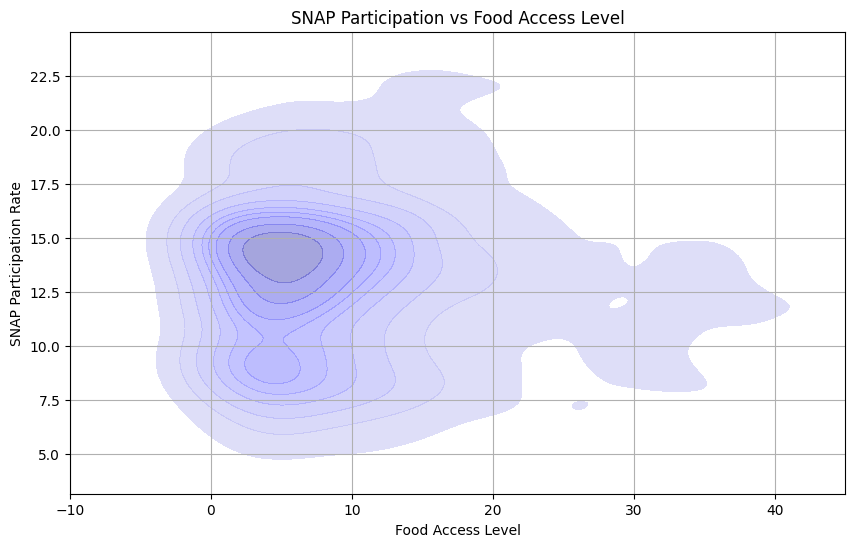

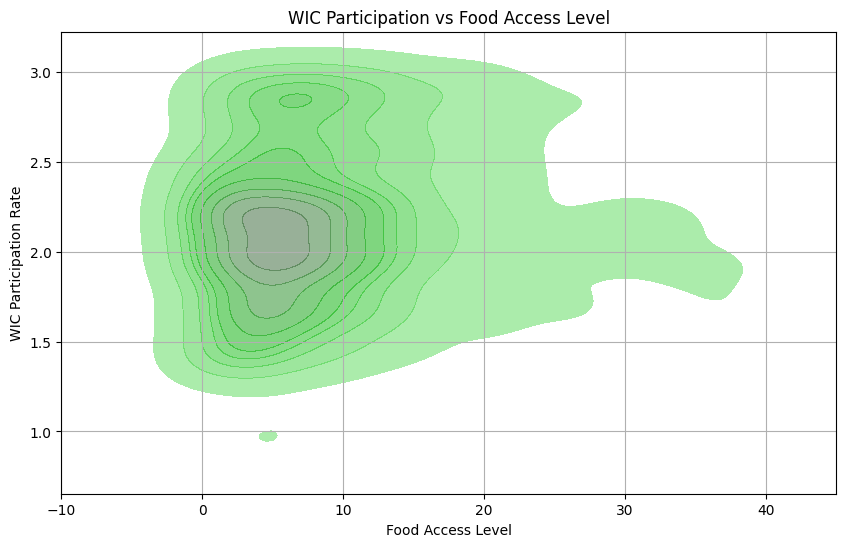

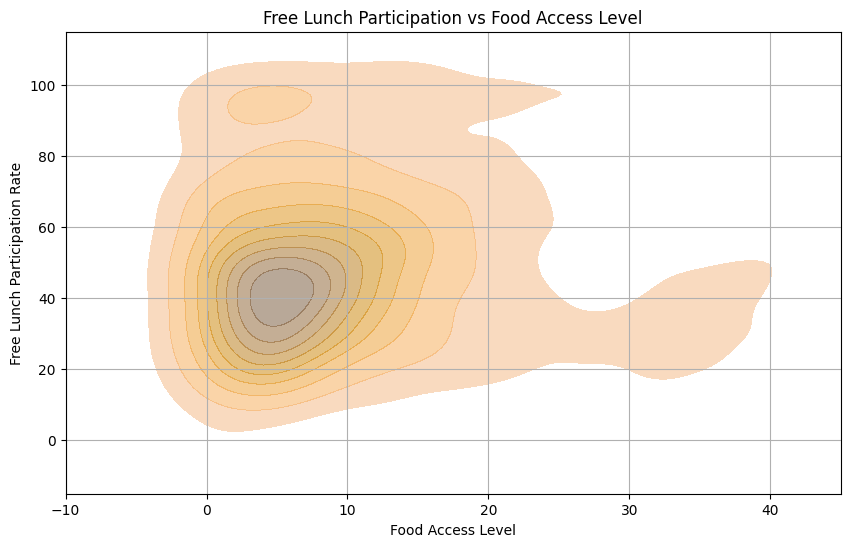

In [ ]:
# DENSITY CONTOUR FOR FOOD PROGRAMS -------------------------------------------------------------------------------

# Plot for SNAP Participation vs Food Access
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='LowIncome_LowAccess', y='Snap_Participation', fill=True, color='blue', alpha=0.5)
plt.title("SNAP Participation vs Food Access Level")
plt.xlabel("Food Access Level")
plt.ylabel("SNAP Participation Rate")
plt.xlim(-10, 45)
plt.grid(True)
plt.show()

# Plot for WIC Participation vs Food Access
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='LowIncome_LowAccess', y='WIC_Participation', fill=True, color='green', alpha=0.5)
plt.title("WIC Participation vs Food Access Level")
plt.xlabel("Food Access Level")
plt.ylabel("WIC Participation Rate")
plt.xlim(-10, 45)
plt.grid(True)
plt.show()

# Plot for Free Lunch Participation vs Food Access
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='LowIncome_LowAccess', y='FreeLunch_Participation', fill=True, color='orange', alpha=0.5)
plt.title("Free Lunch Participation vs Food Access Level")
plt.xlabel("Food Access Level")
plt.ylabel("Free Lunch Participation Rate")
plt.xlim(-10, 45)
plt.grid(True)
plt.show()


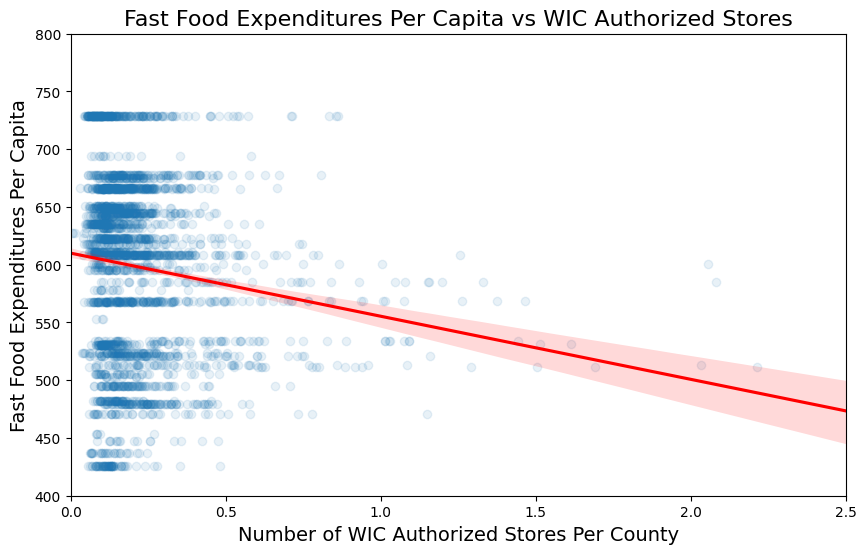

In [ ]:
# FAST FOOD EXPENDITURES PER CAPITA VS WIC AUTHORIZED STORES -------------------------------------------------

plt.figure(figsize=(10, 6))
sns.regplot(data= df, x='WIC_Authorized_Stores_Count', y='Fast_Food_Expenditures_Per_Capita',
            scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
plt.title('Fast Food Expenditures Per Capita vs WIC Authorized Stores', fontsize=16)
plt.xlabel('Number of WIC Authorized Stores Per County', fontsize=14)
plt.ylabel('Fast Food Expenditures Per Capita', fontsize=14)
plt.xlim(0, 2.5)
plt.ylim(400,800)
plt.show()

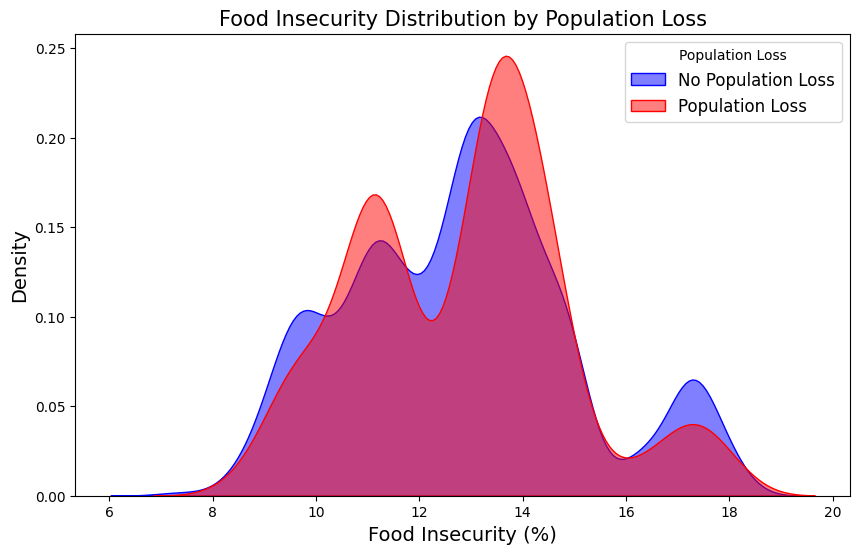

In [ ]:
#  FOOD INSECURITY BY POPULATION LOSS -----------------------------------------------------------------------
plt.figure(figsize=(10, 6))
# counties with no population loss (PopulationLoss == 0)
sns.kdeplot(data=df[df['PopulationLoss'] == 0], x='FoodInsecurity', label='No Population Loss', fill=True, color='blue', alpha=0.5)
# counties with population loss (PopulationLoss == 1)
sns.kdeplot(data=df[df['PopulationLoss'] == 1], x='FoodInsecurity', label='Population Loss', fill=True, color='red', alpha=0.5)
plt.title('Food Insecurity Distribution by Population Loss', fontsize=15)
plt.xlabel('Food Insecurity (%)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title="Population Loss", fontsize=12)
plt.show()

<ipython-input-30-0f7856622cda>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_food_insecurity = df.groupby('AgeGroup')['FoodInsecurity'].mean().reset_index()
<ipython-input-30-0f7856622cda>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_food_insecurity, x='AgeGroup', y='FoodInsecurity', palette='viridis')


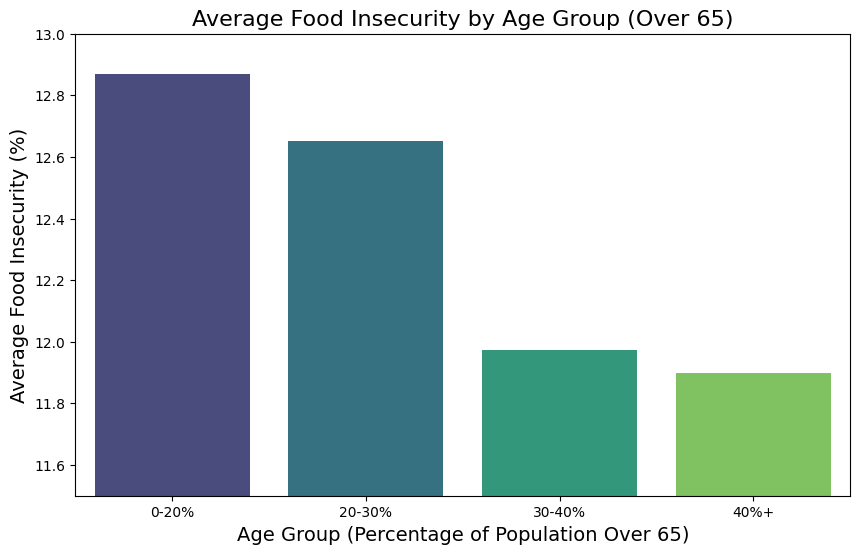

In [ ]:
# FOOD INSECURITY BY AGE GROUP --------------------------------------------------------------------------------
bins = [0, 20, 30, 40, 100]
labels = ['0-20%', '20-30%', '30-40%', '40%+']
df['AgeGroup'] = pd.cut(df['65_Older_Pct'], bins=bins, labels=labels) #new col
avg_food_insecurity = df.groupby('AgeGroup')['FoodInsecurity'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_food_insecurity, x='AgeGroup', y='FoodInsecurity', palette='viridis')
plt.title('Average Food Insecurity by Age Group (Over 65)', fontsize=16)
plt.xlabel('Age Group (Percentage of Population Over 65)', fontsize=14)
plt.ylabel('Average Food Insecurity (%)', fontsize=14)
plt.ylim(11.5,13)
plt.show()